<a href="https://colab.research.google.com/github/aymensrihi/deep-learning-projects/blob/main/vit_spsd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

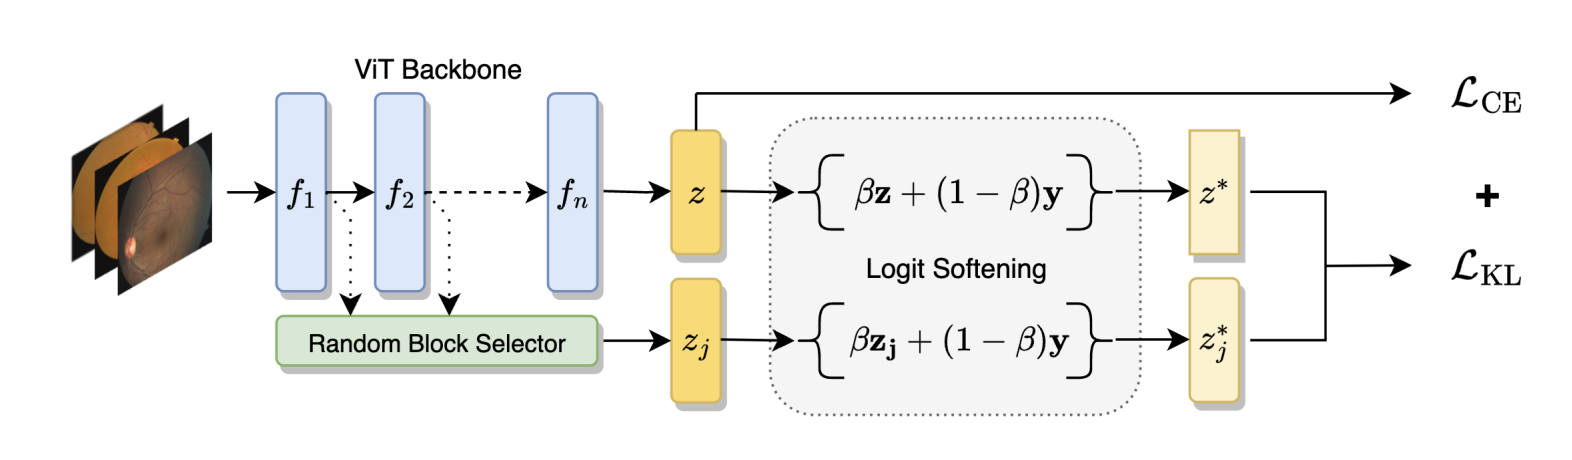

In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from functools import partial
import random
import matplotlib.pyplot as plt
import math

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models import load_pretrained, register_model, resnet26d, resnet50d
from timm import layers


from timm.models import load_pretrained
from timm.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.resnet import resnet26d, resnet50d
from timm.models import register_model




In [ ]:
def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }
default_cfgs = {
    # patch models
    'vit_small_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/vit_small_p16_224-15ec54c9.pth',
    ),
    'vit_base_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vit_base_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_base_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p32_384-830016f5.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_224-4ee7a4dc.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    'vit_large_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_384-b3be5167.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p32_384-9b920ba8.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_huge_patch16_224': _cfg(),
    'vit_huge_patch32_384': _cfg(input_size=(3, 384, 384)),
    # hybrid models
    'vit_small_resnet26d_224': _cfg(),
    'vit_small_resnet50d_s3_224': _cfg(),
    'vit_base_resnet26d_224': _cfg(),
    'vit_base_resnet50d_224': _cfg(),
}

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, return_attention=False, return_all_attention=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        # if(x.shape[0]==1):
        #     attncpy=attn
        # print(attn.shape)
        #     torchvision.utils.save_image(x[0], '/home/computervision1/DG_new_idea/domainbed/scripts/train_output/img1.png')

        attn = attn.softmax(dim=-1)
        attncpy = attn
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        if (return_attention):
            return x, attncpy

        return x

In [ ]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        # self.attens_edit=None # Newly edited
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False, return_all_attention=False):

        # if(x.shape[0]==1):
        #     att,attent=self.attn(self.norm1(x))
        #     x = x + self.drop_path(att)
        #     x = x + self.drop_path(self.mlp(self.norm2(x)))
        #     return x,attent

        # if(return_all_attention):
        #     attn,allattn=self.attn(self.norm1(x),return_all_attention=True)

        if (return_attention):
            attn, attncpy = self.attn(self.norm1(x), return_attention=return_attention)

        attn = self.attn(self.norm1(x))
        x = x + self.drop_path(attn)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        #

        if return_attention:
            return x, attncpy
        # elif return_all_attention:
        #     return allattn
        else:
            return x

In [ ]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """

    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
                # map for all networks, the feature metadata has reliable channel and stride info, but using
                # stride to calc feature dim requires info about padding of each stage that isn't captured.
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        # print('hello')
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        # self.attens_edited=None #  inserted newly.................
        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        # self.repr = nn.Linear(embed_dim, representation_size)
        # self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        ######
        layer_wise_tokens = []
        for blk in self.blocks:
            x = blk(x)
            layer_wise_tokens.append(x)

        layer_wise_tokens = [self.norm(x) for x in layer_wise_tokens]
        return [(x[:, 0]) for x in layer_wise_tokens]

    def forward(self, x,return_feat=False):
        list_out = self.forward_features(x)
        features=list_out
        x = [self.head(x) for x in list_out]
        if(return_feat):
            return x,features
        else:
            return x


    def acc_for_blocks(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        # print('forward features')

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        block_out = []
        preds = []

        for blk in self.blocks:
            x = blk(x)
            block_out.append(x)

        for bl in block_out:
            x = self.norm(bl)
            x = self.head(x[:, 0])
            preds.append(x)

        return preds

    # def acc_for_blocks(self, x):
    #     B = x.shape[0]
    #     x = self.patch_embed(x)
    #     block_out = []
    #     preds = []
    #     preds_dist = []
    #     preds_comb = []
    #     cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
    #     # dist_token = self.dist_token.expand(B, -1, -1)
    #     x = torch.cat((cls_tokens, x), dim=1)

    #     x = x + self.pos_embed
    #     x = self.pos_drop(x)

    #     for blk in self.blocks:
    #         x = blk(x)
    #         block_out.append(x)

    #     for bl in block_out:
    #         x = self.norm(bl)
    #         x_dist = x.detach().clone()
    #         x = self.head(x[:, 0])
    #         # y = self.head_dist(x_dist[:, 1])
    #         # z = (x + y) / 2
    #         preds.append(x)
    #         # preds_dist.append(y)
    #         # preds_comb.append(z)
    #         # print(preds)
    #         return preds

    def forward_selfattention(self, x, return_all_attention=False):
        # print("x.shape:",x.shape)
        B, nc, w, h = x.shape
        # print(self.patch_embed.patch_size)
        x = self.patch_embed(x)

        # interpolate patch embeddings
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size[0]
        h0 = h // self.patch_embed.patch_size[0]
        class_pos_embed = self.pos_embed[:, 0]
        if self.pos_embed.shape[1] == 198:
            N = self.pos_embed.shape[1] - 2
            dist_pos_embed = self.pos_embed[:, 1]
            patch_pos_embed = self.pos_embed[:, 2:]
        else:
            N = self.pos_embed.shape[1] - 1
            patch_pos_embed = self.pos_embed[:, 1:]
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        if w0 != patch_pos_embed.shape[-2]:
            helper = torch.zeros(h0)[None, None, None, :].repeat(1, dim, w0 - patch_pos_embed.shape[-2], 1).to(x.device)
            patch_pos_embed = torch.cat((patch_pos_embed, helper), dim=-2)
        if h0 != patch_pos_embed.shape[-1]:
            helper = torch.zeros(w0)[None, None, :, None].repeat(1, dim, 1, h0 - patch_pos_embed.shape[-1]).to(x.device)
            patch_pos_embed = torch.cat((patch_pos_embed, helper), dim=-1)
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        if self.pos_embed.shape[1] == 198:
            pos_embed = torch.cat((class_pos_embed.unsqueeze(0), dist_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)
        else:
            pos_embed = torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.pos_embed.shape[1] == 198:
            dist_token = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + pos_embed
        x = self.pos_drop(x)

        all_attentions = []
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                if (return_all_attention):
                    x, attn = blk(x, return_attention=True)
                    all_attentions.append(attn)
                else:
                    x = blk(x)
            else:
                x, attn = blk(x, return_attention=True)
                if (return_all_attention):
                    all_attentions.append(attn)
                    return all_attentions

                return attn


In [ ]:
def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict

In [ ]:
@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    if pretrained:
        # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
        kwargs.setdefault('qk_scale', 768 ** -0.5)
    model = VisionTransformer(patch_size=16, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
    model.default_cfg = default_cfgs['vit_small_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model

/tmp/ipython-input-204680792.py:1: UserWarning: Overwriting vit_small_patch16_224 in registry with __main__.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:

@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model

/tmp/ipython-input-1148575963.py:1: UserWarning: Overwriting vit_base_patch16_224 in registry with __main__.vit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model

/tmp/ipython-input-417028729.py:1: UserWarning: Overwriting vit_base_patch16_384 in registry with __main__.vit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_base_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model

/tmp/ipython-input-2937381095.py:1: UserWarning: Overwriting vit_base_patch32_384 in registry with __main__.vit_base_patch32_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_large_patch16_224']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model

/tmp/ipython-input-1667872445.py:1: UserWarning: Overwriting vit_large_patch16_224 in registry with __main__.vit_large_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_large_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model

/tmp/ipython-input-2770751143.py:1: UserWarning: Overwriting vit_large_patch16_384 in registry with __main__.vit_large_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_large_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_large_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model

/tmp/ipython-input-2413081656.py:1: UserWarning: Overwriting vit_large_patch32_384 in registry with __main__.vit_large_patch32_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(patch_size=16, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
    model.default_cfg = default_cfgs['vit_huge_patch16_224']
    return model

In [ ]:
@register_model
def vit_huge_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
    model.default_cfg = default_cfgs['vit_huge_patch32_384']
    return model

In [ ]:
@register_model
def vit_small_resnet26d_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet26d(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_small_resnet26d_224']
    return model

/tmp/ipython-input-703382847.py:1: UserWarning: Overwriting vit_small_resnet26d_224 in registry with __main__.vit_small_resnet26d_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
@register_model
def vit_small_resnet50d_s3_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet50d(pretrained=pretrained_backbone, features_only=True, out_indices=[3])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_small_resnet50d_s3_224']
    return model

In [ ]:
@register_model
def vit_base_resnet26d_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet26d(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_base_resnet26d_224']
    return model

/tmp/ipython-input-3974919172.py:1: UserWarning: Overwriting vit_base_resnet26d_224 in registry with __main__.vit_base_resnet26d_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:

@register_model
def vit_base_resnet50d_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet50d(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_base_resnet50d_224']
    return model

/tmp/ipython-input-452493656.py:1: UserWarning: Overwriting vit_base_resnet50d_224 in registry with __main__.vit_base_resnet50d_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [ ]:
class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain generalization algorithm.
    Subclasses should implement the following:
    - update()
    - predict()
    """

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        """
        Perform one update step, given a list of (x, y) tuples for all
        environments.

        Admits an optional list of unlabeled minibatches from the test domains,
        when task is domain_adaptation.
        """
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

In [ ]:
class ERM_SPSDViT(Algorithm):

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM_SPSDViT, self).__init__(input_shape, num_classes, num_domains,
                                               hparams)
        self.alpha_rb_loss = self.hparams['RB_loss_weight']
        self.alpha_KL_temp = self.hparams['KL_Div_Temperature']
        print('alpha_KL_temp: ', self.alpha_KL_temp)
        print('alpha_rb_loss: ', self.alpha_rb_loss)

        # create model
        backbone=self.hparams['backbone']
        self.network = return_backbone_network(backbone,num_classes,hparams)

        self.optimizer = torch.optim.AdamW(self.network.parameters(),
                                           lr=self.hparams["lr"],
                                           weight_decay=self.hparams['weight_decay']
                                           )

        self.alpha_T = self.hparams['alpha_T']
        print('alpha_T: ', str(self.alpha_T))
        self.n_steps = self.hparams['n_steps']
        print('Total steps: ', str(self.n_steps))
        self.step_count = 0
        self.n_classes = num_classes

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])

        ########################################################################################

        alpha_t = self.alpha_T * ((self.step_count + 1) / self.n_steps)
        alpha_t = max(0, alpha_t)

        output, output_rb = self.predict_Train(all_x)

        targets_numpy = all_y.cpu().detach().numpy()
        identity_matrix = torch.eye(self.n_classes)
        targets_one_hot = identity_matrix[targets_numpy]

        soft_output = ((1 - alpha_t) * targets_one_hot).to('cuda') + (alpha_t * F.softmax(output, dim=1))
        soft_output_rb = ((1 - alpha_t) * targets_one_hot).to('cuda') + (alpha_t * F.softmax(output_rb, dim=1))

        self.step_count += 1

        base_loss = F.cross_entropy(output, all_y)

        rb_loss = F.kl_div(
            torch.log(soft_output_rb),
            torch.log(soft_output),
            reduction='sum',
            log_target=True
        ) * (self.alpha_KL_temp * self.alpha_KL_temp) / output_rb.numel()

        # Final_loss
        loss = base_loss + self.alpha_rb_loss * rb_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item(), 'rb_loss': rb_loss.item()}

    def predict_Train(self, x):
        out = self.network(x)
        block_number = random.randint(0, len(out) - 1)
        return out[-1], out[block_number]

    def predict(self, x):
        out = self.network(x)
        return out[-1]

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import numpy as np

def _hparams(algorithm, dataset, random_seed):
    hparams = {}

    def _hparam(name, default_val, random_val_fn):
        random_state = np.random.RandomState(misc.seed_hash(random_seed, name))
        hparams[name] = (default_val, random_val_fn(random_state))

    # General hyperparameters
    _hparam('data_augmentation', True, lambda r: True)
    _hparam('backbone', "DeitSmall", lambda r: "DeitSmall")
    _hparam('nonlinear_classifier', False, lambda r: False)

    # SPSD-specific hyperparameters
    if algorithm == 'ERM_SPSDViT':
        _hparam('RB_loss_weight', 0.7, lambda r: r.choice([0.5, 0.7, 0.9]))  # λ from paper
        _hparam('KL_Div_Temperature', 4.0, lambda r: r.choice([3.0, 4.0, 5.0]))  # Temperature
        _hparam('alpha_T', 0.8, lambda r: r.choice([0.6, 0.7, 0.8]))  # β from paper
        _hparam('n_steps', 5000, lambda r: 5000)  # Total training steps

    # Dataset-specific (for diabetic retinopathy - 224x224 images)
    _hparam('lr', 5e-5, lambda r: 10 ** r.uniform(-5, -3.5))
    _hparam('weight_decay', 0., lambda r: 10 ** r.uniform(-6, -2))
    _hparam('batch_size', 32, lambda r: int(2 ** r.uniform(3, 5.5)))

    return hparams

def default_hparams(algorithm, dataset):
    return {a: b for a, (b, c) in _hparams(algorithm, dataset, 0).items()}

def random_hparams(algorithm, dataset, seed):
    return {a: c for a, (b, c) in _hparams(algorithm, dataset, seed).items()}

In [ ]:
def return_backbone_network(network_name,num_classes,hparams):
    if(network_name=="DeitSmall"):
        network = torch.hub.load('./domainbed/pretrained_models/DeiT_models', 'deit_small_patch16_224',
                                      pretrained=True, source='local')
        network.head = nn.Linear(384, num_classes)
        return network
    elif(network_name=="DeitBase"):
        network = torch.hub.load('./domainbed/pretrained_models/DeiT_models', 'deit_base_patch16_224',
                                      pretrained=True, source='local')
        network.head = nn.Linear(768, num_classes)
        return network
    elif(network_name=="CVTSmall"):
        network = small_cvt(pretrained=True)
        network.head = nn.Linear(384, num_classes)
        return network
    elif(network_name=="CVTTiny"):
        network = tiny_cvt(pretrained=True)
        network.head = nn.Linear(384, num_classes)
        return network
    elif(network_name=="T2T14"):
        network = t2t_vit_t_14()
        # load the pretrained weights
        pretrained_path = "./domainbed/pretrained_models/t2t/81.7_T2T_ViTt_14.pth.tar"
        load_for_transfer_learning(network, pretrained_path, use_ema=True, strict=True, num_classes=1000)
        network.head = nn.Linear(384, num_classes)
        return network
    elif(network_name=="T2T19"):
        network = t2t_vit_t_19()
        # load the pretrained weights
        pretrained_path = "/share/users/chamuditha/domain_generalization/SDViT/domainbed/pretrained_models/t2t/82.4_T2T_ViTt_19.pth.tar"
        load_for_transfer_learning(network, pretrained_path, use_ema=True, strict=True, num_classes=1000)
        network.head = nn.Linear(448, num_classes)
        return network

In [ ]:
def get_dataset_class(dataset_name):
    """Return the dataset class with the given name."""
    if dataset_name not in globals():
        raise NotImplementedError("Dataset not found: {}".format(dataset_name))
    return globals()[dataset_name]


def num_environments(dataset_name):
    return len(get_dataset_class(dataset_name).ENVIRONMENTS)


class MultipleDomainDataset:
    N_STEPS = 5001           # Default, subclasses may override
    CHECKPOINT_FREQ = 100    # Default, subclasses may override
    N_WORKERS = 10            # Default, subclasses may override
    ENVIRONMENTS = None      # Subclasses should override
    INPUT_SHAPE = None       # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)

class DR(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["aptos", "eyepacs", "messidor", "messidor_2"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

class DR1(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["aptos", "eyepacs"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR1/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

class DR2(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["aptos", "messidor"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR2/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

class DR3(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["aptos", "messidor_2"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR3/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

class DR4(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["eyepacs", "messidor_2"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR4/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

class DR5(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["eyepacs", "messidor"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR5/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

class DR6(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 100
    ENVIRONMENTS = ["messidor", "messidor_2"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "DR6/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)
